***Libary***

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
import statsmodels.api as sm
import pandas as pd
from datetime import datetime

from sklearn.preprocessing import PolynomialFeatures

***Set up data***

In [3]:
df = pd.read_csv(r'COVID19_Qc.csv')

# drop row that are 0
df.drop(df.loc[df['Nb_Cas_Cumulatif']==0].index, inplace=True)
df

# select column
case_df = df[['Date','Nb_Nvx_Cas']]
case_df.rename(columns={'Nb_Nvx_Cas':'Case'})

# only select data in 2020
case_df['Date'] = pd.to_datetime(case_df['Date'])
case_df = case_df[case_df['Date'].dt.year == 2020]

# cut off point 31/8/2020

month = [7,8,9,10]
reg_case = case_df[case_df['Date'].dt.month.isin(month)] # select a month before and after cutoff

cut_off = datetime.strptime('2020-08-31', "%Y-%m-%d")

# centerlize data
reg_case['date_diff'] = reg_case['Date'] - cut_off
reg_case['date_diff'] = reg_case['date_diff'].astype('timedelta64[D]')

reg_case

C:\Users\rusy_\AppData\Local\Temp\ipykernel_23032\1033660882.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case_df['Date'] = pd.to_datetime(case_df['Date'])
C:\Users\rusy_\AppData\Local\Temp\ipykernel_23032\1033660882.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_case['date_diff'] = reg_case['Date'] - cut_off
C:\Users\rusy_\AppData\Local\Temp\ipykernel_23032\1033660882.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,Date,Nb_Nvx_Cas,date_diff
161,2020-07-01,83,-61.0
162,2020-07-02,70,-60.0
163,2020-07-03,87,-59.0
164,2020-07-04,92,-58.0
165,2020-07-05,53,-57.0
...,...,...,...
279,2020-10-27,1072,57.0
280,2020-10-28,930,58.0
281,2020-10-29,1016,59.0
282,2020-10-30,975,60.0


In [4]:
df

,Date,Nb_Cas_Cumulatif,Nb_Nvx_Cas,Nb_Deces_Cumulatif_Total,Nb_Deces_Cumulatif_CHCHSLD,Nb_Deces_Cumulatif_RPA,Nb_Deces_Cumulatif_DomInc,Nb_Deces_Cumulatif_Autre,Nb_Nvx_Deces_Total,Nb_Nvx_Deces_CHCHSLD,Nb_Nvx_Deces_RPA,Nb_Nvx_Deces_DomInc,Nb_Nvx_Deces_Autre
44,2020-03-06,1,1,0,0,0,0,0,0,0,0,0,0
45,2020-03-07,1,0,0,0,0,0,0,0,0,0,0,0
46,2020-03-08,1,0,0,0,0,0,0,0,0,0,0,0
47,2020-03-09,1,0,0,0,0,0,0,0,0,0,0,0
48,2020-03-10,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,2023-01-03,1287390,931,17623,6818,3398,6641,766,5,2,1,2,0
1078,2023-01-04,1288483,1093,17628,6819,3399,6644,766,5,1,1,3,0
1079,2023-01-05,1289363,880,17637,6820,3400,6650,767,9,1,1,6,1
1080,2023-01-06,1290132,769,17645,6820,3400,6658,767,8,0,0,8,0


<AxesSubplot:xlabel='date_diff', ylabel='Nb_Nvx_Cas'>

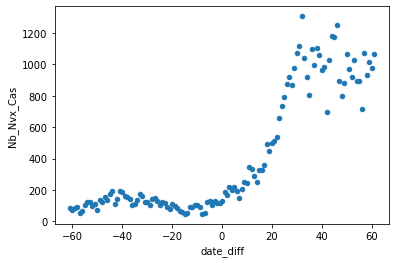

In [5]:
reg_case.plot.scatter(x='date_diff', y='Nb_Nvx_Cas')

In [6]:
reg_case.head()

,Date,Nb_Nvx_Cas,date_diff
161,2020-07-01,83,-61.0
162,2020-07-02,70,-60.0
163,2020-07-03,87,-59.0
164,2020-07-04,92,-58.0
165,2020-07-05,53,-57.0


***Regression model***

In [28]:
reg_case['stage'] = None
reg_case.loc[reg_case['date_diff']<0, 'stage'] = 0
reg_case.loc[reg_case['date_diff']>=0, 'stage'] = 1

C:\Users\rusy_\AppData\Local\Temp\ipykernel_23032\1075309514.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_case['stage'] = None


**Regression model : per-lockdown**

In [29]:
per_case = reg_case[reg_case['stage']==0]

X_p = np.array(per_case['date_diff']*-1)
X1_p = sm.add_constant(X_p)
y_p = per_case['Nb_Nvx_Cas']

reg_per = sm.WLS(y_p, X1_p).fit()

In [30]:
reg_per.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.030
Model:                            WLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.798
Date:                Wed, 11 Jan 2023   Prob (F-statistic):              0.185
Time:                        21:47:10   Log-Likelihood:                -304.04
No. Observations:                  61   AIC:                             612.1
Df Residuals:                      59   BIC:                             616.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        102.4115      9.320     10.989      0.000      83.763     121.060
x1             0.3506      0.261      1.341      0.185      -0.173       0.874
==============================================================================
Omnibus:                        0.683   Durbin-Watson:                   0.604
Prob(Omnibus):                  0.711   Jarque-Bera (JB):                0.765
Skew:                           0.105   Prob(JB):                        0.682
Kurtosis:                       2.493   Cond. No.                         72.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Regression model : post-lockdown**

In [31]:
post_case = reg_case[reg_case['stage']==1]

X_po = np.array(post_case['date_diff'])
X1_po = sm.add_constant(X_po)
y_po = post_case['Nb_Nvx_Cas']

reg_post = sm.WLS(y_po, X1_po).fit()

In [32]:
reg_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.701
Model:                            WLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     140.9
Date:                Wed, 11 Jan 2023   Prob (F-statistic):           2.19e-17
Time:                        21:47:17   Log-Likelihood:                -413.81
No. Observations:                  62   AIC:                             831.6
Df Residuals:                      60   BIC:                             835.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        219.6866     48.881      4.494      0.000     121.911     317.462
x1            16.4074      1.382     11.870      0.000      13.642      19.172
==============================================================================
Omnibus:                        4.343   Durbin-Watson:                   0.431
Prob(Omnibus):                  0.114   Jarque-Bera (JB):                4.111
Skew:                           0.627   Prob(JB):                        0.128
Kurtosis:                       2.871   Cond. No.                         69.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
pred_percs = reg_per.fittedvalues
pred_postcs = reg_post.fittedvalues

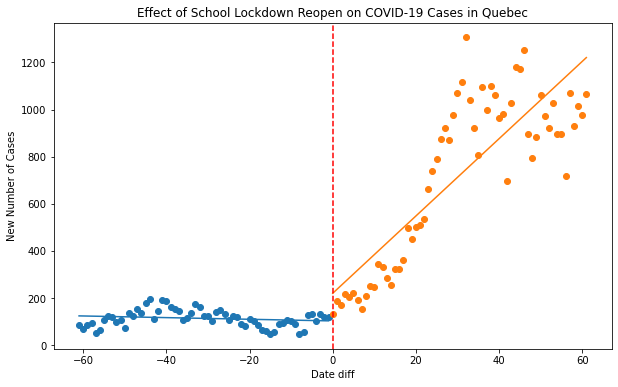

In [34]:
fig, ax = plt.subplots(figsize=(10,6))

# plot per and post lockdown
ax.scatter(X1_p[:,1]*-1, y_p)
ax.plot(X1_p[:,1]*-1, pred_percs)
ax.scatter(X1_po[:,1], y_po)
ax.plot(X1_po[:,1], pred_postcs)

# plot format
ax.set_title('Effect of School Lockdown Reopen on COVID-19 Cases in Quebec')
ax.set_ylabel('New Number of Cases')
ax.set_xlabel('Date diff')
ax.axvline(0,color='red',alpha=1, ls = '--', label = 'School Lockdown Reopen - 2020/8/31')

plt.show()

**Polynomial Regression model**

**Per-lockdown regression**

In [35]:
poly_fea = PolynomialFeatures(degree=2)
X1_p_p2 = poly_fea.fit_transform(X_p.reshape(-1, 1))

poly_reg_per = sm.WLS(y_p, X1_p_p2).fit()

poly_reg_per.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.191
Model:                            WLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     6.863
Date:                Wed, 11 Jan 2023   Prob (F-statistic):            0.00211
Time:                        21:47:22   Log-Likelihood:                -298.48
No. Observations:                  61   AIC:                             603.0
Df Residuals:                      58   BIC:                             609.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.5044     13.141      5.213      0.000      42.200      94.809
x1             3.5798      0.978      3.660      0.001       1.622       5.537
x2            -0.0521      0.015     -3.407      0.001      -0.083      -0.021
==============================================================================
Omnibus:                        1.819   Durbin-Watson:                   0.725
Prob(Omnibus):                  0.403   Jarque-Bera (JB):                1.435
Skew:                           0.187   Prob(JB):                        0.488
Kurtosis:                       2.349   Cond. No.                     5.28e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

***Post-lockdown regression***

In [36]:
X1_po_p2 = poly_fea.fit_transform(X_po.reshape(-1, 1))

poly_reg_post = sm.WLS(y_po, X1_po_p2).fit()

poly_reg_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.832
Model:                            WLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     146.3
Date:                Wed, 11 Jan 2023   Prob (F-statistic):           1.36e-23
Time:                        21:47:23   Log-Likelihood:                -395.94
No. Observations:                  62   AIC:                             797.9
Df Residuals:                      59   BIC:                             804.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -50.4946     54.336     -0.929      0.357    -159.221      58.231
x1            43.4255      4.119     10.544      0.000      35.184      51.667
x2            -0.4429      0.065     -6.782      0.000      -0.574      -0.312
==============================================================================
Omnibus:                        0.644   Durbin-Watson:                   0.769
Prob(Omnibus):                  0.725   Jarque-Bera (JB):                0.638
Skew:                           0.230   Prob(JB):                        0.727
Kurtosis:                       2.810   Cond. No.                     4.91e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
p2_pred_percs = poly_reg_per.fittedvalues
p2_pred_postcs = poly_reg_post.fittedvalues

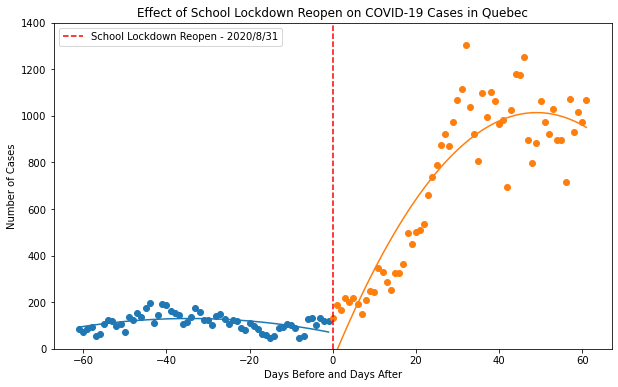

In [38]:
fig, ax = plt.subplots(figsize=(10,6))

# plot per and post lockdown
ax.scatter(X1_p_p2[:,1]*-1, y_p)
ax.plot(X1_p_p2[:,1]*-1, p2_pred_percs)
ax.scatter(X1_po_p2[:,1], y_po)
ax.plot(X1_po_p2[:,1], p2_pred_postcs)

# plot format
ax.set_ylim([0, 1400])
ax.set_title('Effect of School Lockdown Reopen on COVID-19 Cases in Quebec')
ax.set_ylabel('Number of Cases')
ax.set_xlabel('Days Before and Days After')
ax.axvline(0,color='red',alpha=1, ls = '--', label = 'School Lockdown Reopen - 2020/8/31')

plt.legend()
plt.show()

***Effect of lockdown measure***

In [47]:
X = reg_case['stage'].astype(int)
X1 = sm.add_constant(X)
y  = reg_case['Nb_Nvx_Cas']

effect_reg = sm.OLS(y, X1).fit()
effect_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     177.9
Date:                Wed, 11 Jan 2023   Prob (F-statistic):           1.61e-25
Time:                        21:52:04   Log-Likelihood:                -853.77
No. Observations:                 123   AIC:                             1712.
Df Residuals:                     121   BIC:                             1717.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        113.2787     32.299      3.507      0.001      49.335     177.223
stage        606.8342     45.493     13.339      0.000     516.769     696.900
==============================================================================
Omnibus:                        5.193   Durbin-Watson:                   0.181
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                4.758
Skew:                          -0.471   Prob(JB):                       0.0926
Kurtosis:                       3.200   Cond. No.                         2.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

***P-value interpretation***

P-value for the effect of the reopening is 0.00, this is smaller than 0.05. We can reject the null and state that lockdown reopening has statistically significant effect on covid-19. The coef for reopening is 606.8342, which is positive correlated to number of case, therefore, it means reopening lockdown increase the number of covid-19 case.

***Justification for regression design***

The dependent variable we choose to measure is the number of new cases for each day and indenpent variable is the number of days before and after lockdown reopenning. We choose new cases each days because we think number of new case shows an intutive effect of COVID-19, and can gives us a insightful idea on the effect of reopening.

We included 60 days (2 months) before and after lockdown because we noticed that case increase after roughly 2 weeks after the lockdown, it is because covid 19 incubation period is around 14 days and as show on the plot below, the number of cases increasing until 40-50 days after the reopening. Therefore, we think 2 months period before and after the reopening is a reasonable timeframe.

We also use a 2 degress polynomial regression because we found that the R-square is higher and AIB,BIC lower with 2 degree polynomial, which means the model is more accurate with 2 degree polynomial. Also, we can tell from the RDD regression plot, number of case start to drop after 50-60 days, this effect can only be seen on polynomial regression. 

<AxesSubplot:xlabel='date_diff', ylabel='Nb_Nvx_Cas'>

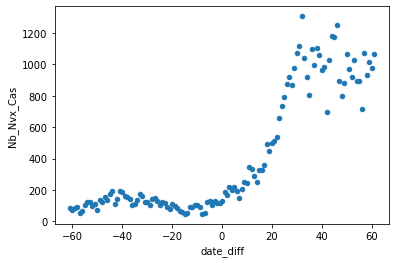

In [49]:
reg_case.plot.scatter(x='date_diff', y='Nb_Nvx_Cas')